# Imports and Constants

In [1]:
import os
import random
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn import model_selection
from matplotlib import pyplot as plt

import PIL
# https://github.com/tensorflow/tensorflow/issues/46840
# https://stackoverflow.com/a/68239032/12405558
if PIL.__version__ == "8.3.0":
    raise ImportError(f"PIL 8.3.0 is incompatible with tensorflow 2.6.0")
    
abspath_join = lambda a, *p: os.path.abspath(os.path.join(a, *p))

BASE_DATA_DIR = "/data"
TRAIN_DIR = os.path.join(BASE_DATA_DIR, "train")
TEST_DIR = os.path.join(BASE_DATA_DIR, "test")

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNEL = 3
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNEL)

# Split training into training and validation dataset
VALIDATION_SIZE = 0.2

BATCH_SIZE = 20
EPOCHS = 50

TYPE = {"cat": 0, "dog": 1}

# Prepare Training Data

## Setup for Google Colab

In [2]:
try:
    from google.colab import drive
    from zipfile import ZipFile
    
    MOUNT = "/content/drive"
    drive.mount(MOUNT, force_remount=True)

    BASE_DATA_DIR = "/content/data"
    TRAIN_DIR = abspath_join(BASE_DATA_DIR, "train")
    TEST_DIR = abspath_join(BASE_DATA_DIR, "test1")
    for zip_name in ("test1.zip","train.zip"):
        try:
            zip_dir = abspath_join(MOUNT, "MyDrive/AI/data", zip_name)
            with ZipFile(zip_dir, "r") as zip_ref:
                print(f"Unzipping {zip_name}")
                zip_ref.extractall(BASE_DATA_DIR)
        except:
            print(f"{zip_name} not found")
except ImportError:
    pass

## Setup for Kaggle

In [3]:
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', None):
    from glob import glob
    from zipfile import ZipFile
    print('Extracting the data from dataset...')
    zip_files = glob('/kaggle/input/dogs-vs-cats/*.zip')
    print(f'{len(zip_files)} files found in the input directory')
    for file in zip_files:
        print(f"Unzipping {file.split('/')[-1]}")
        with ZipFile(file, 'r') as Z:
            Z.extractall('data')
        print("Done")
    BASE_DATA_DIR = '/kaggle/working/data'
    TRAIN_DIR = abspath_join(BASE_DATA_DIR, "train")
    TEST_DIR = abspath_join(BASE_DATA_DIR, "test1")

Extracting the data from dataset...
2 files found in the input directory
Unzipping test1.zip
Done
Unzipping train.zip
Done


In [4]:
train_set = os.listdir(TRAIN_DIR)
types = [filename.split(".")[0] for filename in train_set]
df = pd.DataFrame({"filename": train_set, "class": types})

train_df, val_df = model_selection.train_test_split(df, test_size=VALIDATION_SIZE)

TOTAL_TRAIN = train_df.shape[0]
TOTAL_VAL = val_df.shape[0]

len(train_set)

25000

## Some samples

In [5]:
df["class"].value_counts() #.rename({v: k for k, v in TYPE.items()})

cat    12500
dog    12500
Name: class, dtype: int64

In [6]:
print(f"Training: {len(train_df)}")
train_df.reset_index(drop=True)["class"].value_counts()

Training: 20000


cat    10037
dog     9963
Name: class, dtype: int64

In [7]:
print(f"Validation: {len(val_df)}")
val_df.reset_index(drop=True)["class"].value_counts()

Validation: 5000


dog    2537
cat    2463
Name: class, dtype: int64

# Build Model

In [8]:
from tensorflow.keras import models, layers, losses

# https://www.tensorflow.org/guide/keras/functional
img_input = layers.Input(shape=IMG_SHAPE)

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, (3, 3), activation="relu")(img_input)
x = layers.MaxPool2D((2, 2))(x)  # Stack layer

# Same as previous convolution but with 32 filters
x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Dropout(0.25)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation="relu")(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation="sigmoid")(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + 
# fully connected layer + sigmoid output layer
model = models.Model(img_input, output)

model.compile(loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0     

## Model diagram

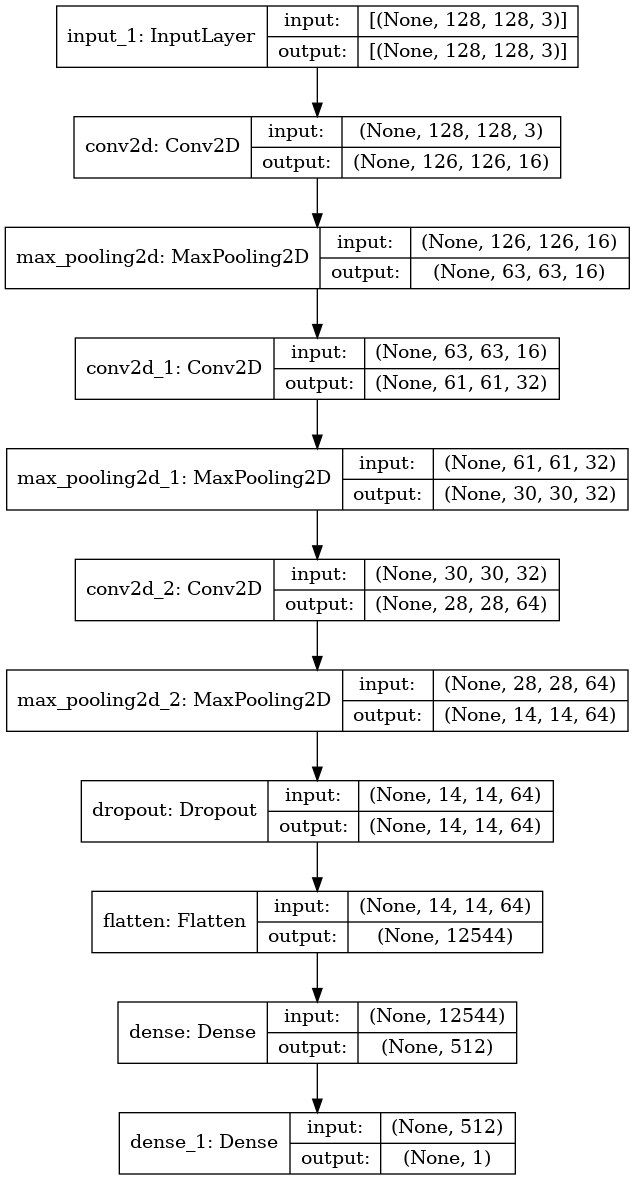

In [9]:
keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

# Data Preprocessing

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATAGEN_PARAMS = {
    "rescale": 1.0 / 255,
    "horizontal_flip": True,
    "zoom_range": 0.1,
    "rotation_range": 35,
    "height_shift_range": 0.2,
    "width_shift_range": 0.2,
}

GEN_PARAMS = {
    "directory": TRAIN_DIR,
    "target_size": IMG_SIZE,
    "batch_size": BATCH_SIZE,
    "class_mode": "binary",
}

train_datagen = ImageDataGenerator(**DATAGEN_PARAMS)
val_datagen = ImageDataGenerator(**DATAGEN_PARAMS)

train_gen = train_datagen.flow_from_dataframe(train_df, **GEN_PARAMS)
val_gen = val_datagen.flow_from_dataframe(val_df, **GEN_PARAMS)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


Here we take an image and see how our `ImageDataGenerator` augment the image for each epoch (assume that `steps_per_epoch=TOTAL_TRAIN // BATCH_SIZE`)    

Detail here: https://stackoverflow.com/questions/51748514/does-imagedatagenerator-add-more-images-to-my-dataset

Found 1 validated image filenames belonging to 1 classes.


,index,filename,class
0,7496,cat.10512.jpg,cat


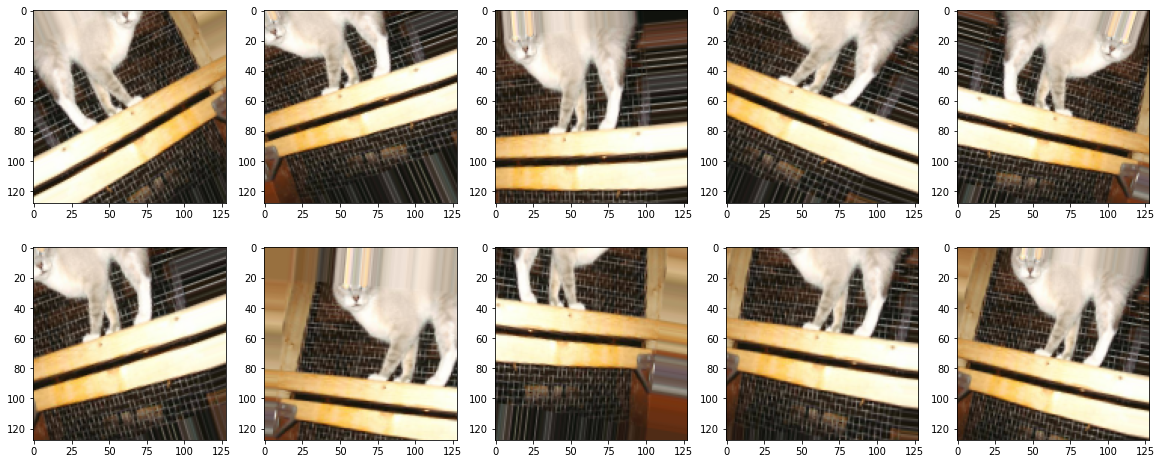

In [11]:
GEN_PARAMS.pop("class_mode", None)
SHAPE = (2,5)
FIGSIZE = (20,8)
IMG_IDX = None
if IMG_IDX is None: # Pick random
    sample_df = train_df.sample(n=1).reset_index()
else:
    sample_df = train_df.loc[[IMG_IDX], :]
sample_gen = train_datagen.flow_from_dataframe(
    sample_df,
    **GEN_PARAMS,
)

fig = plt.figure(figsize=FIGSIZE)
for i in range(0, SHAPE[0]*SHAPE[1]):
    fig.add_subplot(SHAPE[0], SHAPE[1], i + 1)
    x_batch, _ = next(sample_gen)
    image = x_batch[0]
    plt.imshow(image)
display(sample_df)
plt.show()


# Training

In [12]:
from tensorflow.keras import callbacks

lr_reduction = callbacks.ReduceLROnPlateau(
    monitor="val_acc", patience=2, verbose=1, factor=0.5, min_lr=0.00001
)
early_stop = callbacks.EarlyStopping(patience=10)

In [13]:
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=TOTAL_VAL // BATCH_SIZE,
    steps_per_epoch=TOTAL_TRAIN // BATCH_SIZE,
    callbacks=[lr_reduction, early_stop]
)

Epoch 1/50
1000/1000 [==============================] - 307s 306ms/step - loss: 0.6763 - accuracy: 0.5892 - val_loss: 0.5846 - val_accuracy: 0.6860
Epoch 2/50
1000/1000 [==============================] - 290s 289ms/step - loss: 0.5945 - accuracy: 0.6863 - val_loss: 0.5804 - val_accuracy: 0.6980
Epoch 3/50
1000/1000 [==============================] - 290s 290ms/step - loss: 0.5590 - accuracy: 0.7139 - val_loss: 0.5458 - val_accuracy: 0.7164
Epoch 4/50
1000/1000 [==============================] - 283s 282ms/step - loss: 0.5518 - accuracy: 0.7179 - val_loss: 0.5372 - val_accuracy: 0.7388
Epoch 5/50
1000/1000 [==============================] - 281s 281ms/step - loss: 0.5340 - accuracy: 0.7388 - val_loss: 0.5374 - val_accuracy: 0.7320
Epoch 6/50
1000/1000 [==============================] - 285s 285ms/step - loss: 0.5216 - accuracy: 0.7515 - val_loss: 0.4856 - val_accuracy: 0.7778
Epoch 7/50
1000/1000 [==============================] - 282s 282ms/step - loss: 0.5138 - accuracy: 0.7562 - val_

## Save Model

In [14]:
model.save_weights("model.v2")
history.history['accuracy']

[0.6305000185966492,
 0.6934999823570251,
 0.7135999798774719,
 0.727649986743927,
 0.7430999875068665,
 0.7498499751091003,
 0.7569500207901001,
 0.7632499933242798,
 0.770550012588501,
 0.7748500108718872,
 0.7831000089645386,
 0.78329998254776,
 0.7867000102996826,
 0.7901999950408936,
 0.7918000221252441,
 0.7950500249862671,
 0.7953000068664551,
 0.7985000014305115,
 0.8014500141143799,
 0.7985000014305115,
 0.7961500287055969,
 0.7976999878883362,
 0.8041999936103821,
 0.802299976348877,
 0.8061000108718872,
 0.8079500198364258,
 0.8083500266075134,
 0.8041499853134155,
 0.8010500073432922,
 0.8041499853134155,
 0.8098000288009644,
 0.8069999814033508,
 0.8135499954223633,
 0.8094000220298767,
 0.8049499988555908,
 0.8069499731063843,
 0.8099499940872192,
 0.8112499713897705,
 0.8104000091552734,
 0.8076000213623047,
 0.8093000054359436,
 0.8106499910354614,
 0.8152499794960022,
 0.815500020980835,
 0.8167999982833862,
 0.8154500126838684]

## Virtualize Training

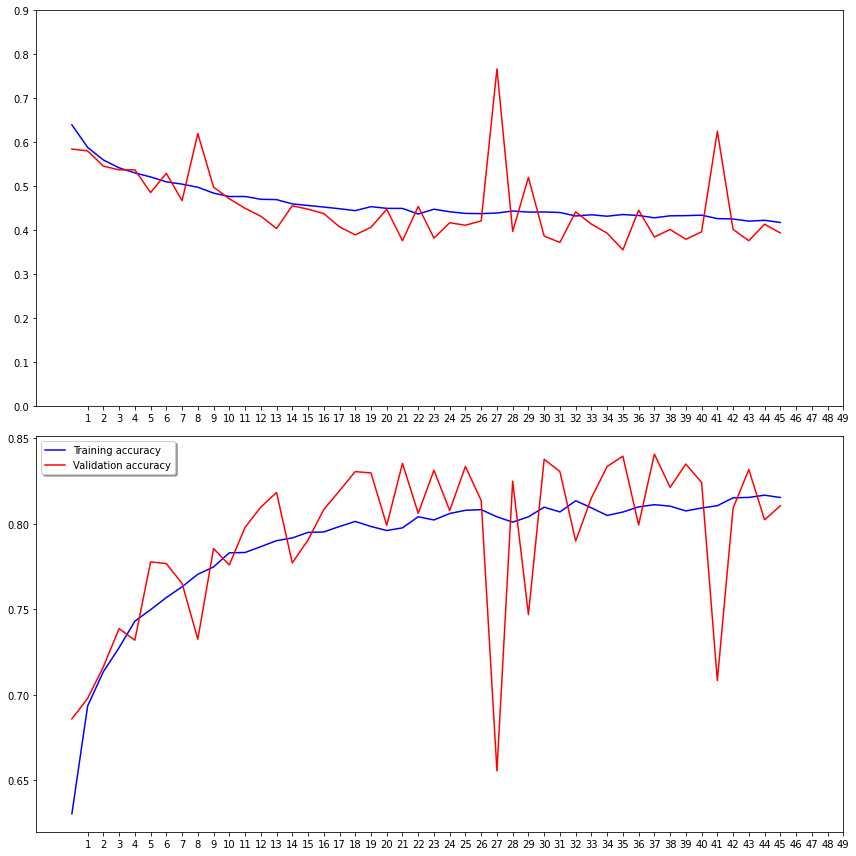

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()